- Importación de librerías


In [17]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

- Carga de datos de Yahoo Finance

In [18]:
stock_data = yf.download("AAPL", start="2020-01-01", end="2024-01-01")
stock_prices = stock_data['Close'].values  # Using closing prices

[*********************100%%**********************]  1 of 1 completed


## Q-LEARNING

In [19]:
# Definición parámetros
num_states = 100  
num_actions = 3  
epsilon = 0.1  
learning_rate = 0.1  
discount = 0.95  
episodes = 1000
episodes_display = 100

# Inicialización Q-table
q_table = np.zeros((num_states, num_actions))

# Función de discretización para convertir el precio de la acción a valor discreto
def discretised_state(price, price_range):
    return min(int(price / price_range * num_states), num_states - 1)

# Elección de acción basado en el estado actual (política e-greedy) 
def choose_action(curr_discrete_state):
    if np.random.rand() < epsilon:
        return np.random.randint(0, num_actions)  # Exploración
    else:
        return np.argmax(q_table[curr_discrete_state])  # Explotación

# Función de recompensa
def get_reward(action, price_change):
    if action == 0:  # Buy
        return price_change
    elif action == 2:  # Sell
        return -price_change
    else:  # Hold
        return 0

# Tabla de recompensa
price_range = max(stock_prices) - min(stock_prices)
ep_rewards = []
ep_rewards_table = {'ep': [], 'avg': [], 'min': [], 'max': []}

for episode in range(episodes):
    episode_reward = 0
    state_array = stock_prices[0]  # Obtener solo el array del estado
    curr_discrete_state = discretised_state(state_array, price_range)  # Estado inicial del entorno discretizado
    done = False
    i = 0  # Contador para el paso del tiempo
    
    # Determinar si se debe renderizar el estado en este episodio
    if episode % episodes_display == 0:
        render_state = True
    else:
        render_state = False

    while not done:
        if np.random.random() > epsilon:  # Decide si el agente debe realizar una acción aleatoria o seleccionar la acción óptima basada en el valor Q actual   
            action = np.argmax(q_table[curr_discrete_state])  # Acción óptima
        else:
            action = np.random.randint(0, num_actions)  # Acción aleatoria
        
        # Obtener el resultado del paso
        if i < len(stock_prices) - 1:
            new_state_array = stock_prices[i + 1]
            reward = get_reward(action, new_state_array - state_array)
            new_discrete_state = discretised_state(new_state_array, price_range)
            done = False
        else:
            new_state_array = state_array
            reward = 0
            new_discrete_state = curr_discrete_state
            done = True
        
        # Actualizar la tabla Q
        if not done:
            max_future_q = np.max(q_table[new_discrete_state])  # Valor máximo esperado de todas las acciones posibles
            current_q = q_table[curr_discrete_state, action]  # Valor Q actual asociado con la acción actual
            new_q = current_q + learning_rate * (reward + discount * max_future_q - current_q)  # Actualizar los valores en la tabla Q
            
            q_table[curr_discrete_state, action] = new_q
    
        i += 1
        curr_discrete_state = new_discrete_state
        episode_reward += reward

    ep_rewards.append(episode_reward)
    
    if not episode % episodes_display: 
        avg_reward = sum(ep_rewards[-episodes_display:])/len(ep_rewards[-episodes_display:])  # si el número actual es divisible, mostrar resultado        
        ep_rewards_table['ep'].append(episode)
        ep_rewards_table['avg'].append(avg_reward)
        ep_rewards_table['min'].append(min(ep_rewards[-episodes_display:]))
        ep_rewards_table['max'].append(max(ep_rewards[-episodes_display:]))          
        print(f"Episode:{episode} avg:{avg_reward} min:{min(ep_rewards[-episodes_display:])} max:{max(ep_rewards[-episodes_display:])}")



Episode:0 avg:59723.46863937378 min:59723.46863937378 max:59723.46863937378
Episode:100 avg:59227.292693901065 min:57152.896255493164 max:61490.84117126465
Episode:200 avg:59558.91857517242 min:56880.73373031616 max:61897.64625167847
Episode:300 avg:59872.53420337677 min:57869.876247406006 max:61597.188762664795
Episode:400 avg:59611.53077655792 min:57320.003871917725 max:61778.311294555664
Episode:500 avg:59570.770583686826 min:57153.04902267456 max:61635.67877578735
Episode:600 avg:59802.564236717226 min:57269.428844451904 max:62167.171352386475
Episode:700 avg:59703.771418113705 min:57625.31636810303 max:61359.48878097534
Episode:800 avg:59725.764616851804 min:56881.35628890991 max:61494.42128753662
Episode:900 avg:59809.39134212494 min:57502.06649017334 max:61828.746253967285


In [20]:
# Guardar tabla Q
q_table_df = pd.DataFrame(q_table, columns=["Buy", "Hold", "Sell"])
q_table_df.to_csv('q_table.csv', index=False)

print(q_table_df)

ep_rewards_df = pd.DataFrame(ep_rewards_table)
print(ep_rewards_df)


            Buy         Hold         Sell
0      0.000000     0.000000     0.000000
1      0.000000     0.000000     0.000000
2      0.000000     0.000000     0.000000
3      0.000000     0.000000     0.000000
4      0.000000     0.000000     0.000000
..          ...          ...          ...
95  1417.593082  1320.987994  1290.487970
96  1478.102688  1393.191769  1364.987572
97  1638.349994  1614.480651  1516.266255
98  1563.664828  1538.148714  1505.006238
99  1907.519798  1630.950481  1556.394104

[100 rows x 3 columns]
    ep           avg           min           max
0    0  59723.468639  59723.468639  59723.468639
1  100  59227.292694  57152.896255  61490.841171
2  200  59558.918575  56880.733730  61897.646252
3  300  59872.534203  57869.876247  61597.188763
4  400  59611.530777  57320.003872  61778.311295
5  500  59570.770584  57153.049023  61635.678776
6  600  59802.564237  57269.428844  62167.171352
7  700  59703.771418  57625.316368  61359.488781
8  800  59725.764617  56881.356

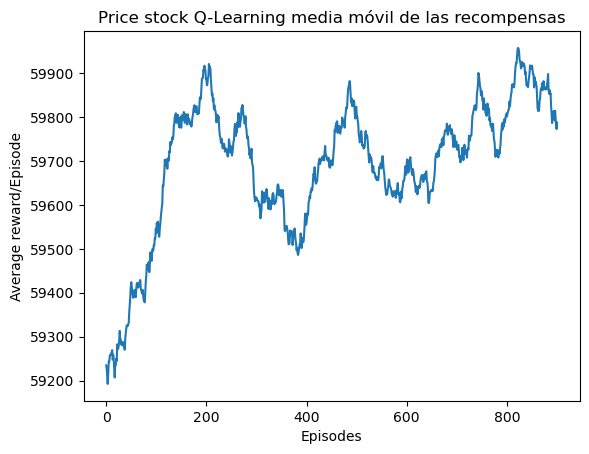

In [22]:
window_size = 100
# A continuación, se multiplican los valores de la ventana por los valores de la recompensas obtenidas y posteriormente
# se suma todo
moving_avg_rewards = np.convolve(ep_rewards, np.ones(window_size)/window_size, mode='valid') #para que todos los valores en la ventana sumen 1
                                                                 # mode=valid para que solo multiplique aquellas secuencias que se superpongan
                                                                # completamente.

# Graficamos la recompensa promedio móvil
plt.plot(np.arange(len(moving_avg_rewards)), moving_avg_rewards)
plt.title('Price stock Q-Learning media móvil de las recompensas')
plt.ylabel('Average reward/Episode')
plt.xlabel('Episodes')
plt.show()

In [26]:
# Calculamos la tasa de convergencia 
convergence_rate = (ep_rewards_table['avg'][-1] - ep_rewards_table['avg'][0]) / len(ep_rewards_table['avg'])
print("Tasa de convergencia:", convergence_rate)

Tasa de convergencia: 8.59227027511588
